## This code from [here](https://dacon.io/competitions/official/235747/codeshare/3054?page=1&dtype=recent).

적용 스킬

In [17]:
# load data
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [2]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [2]:
topic_dict = pd.read_csv("../data/topic_dict.csv")
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## EDA

In [5]:
train['topic_idx'].value_counts()

topic_idx
4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: count, dtype: int64

In [8]:
train['topic_idx'].value_counts(normalize=True)

topic_idx
4    0.167105
2    0.161256
5    0.151860
6    0.147873
1    0.136286
3    0.129956
0    0.105664
Name: proportion, dtype: float64

In [9]:
train.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [20]:
train['title_length'] = train['title'].apply(lambda x: len(x))

In [21]:
train['title_length'].describe()

count    45654.000000
mean        27.330552
std          4.968172
min          4.000000
25%         25.000000
50%         28.000000
75%         31.000000
max         44.000000
Name: title_length, dtype: float64

In [22]:
train.head()

,index,title,topic_idx,title_length
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,24
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,30
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,30
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,32
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,25


<Axes: ylabel='Frequency'>

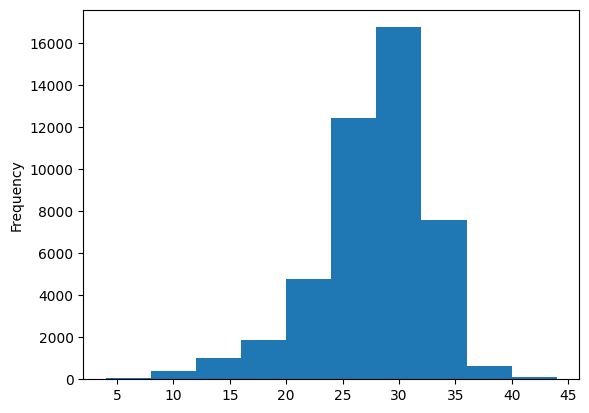

In [23]:
train['title_length'].plot(kind='hist')

In [34]:
train[(train['title_length'] > 10) & (train['title_length'] < 15)]

,index,title,topic_idx,title_length
120,120,정의당 아베정권 규탄한다,6,13
207,207,본회의 출석한 염동열,6,11
209,209,박원순 선거사무소 개소식,6,13
323,323,인사말하는 민병욱 이사장,6,13
426,426,북악산 산행하는 문 대통령,6,14
...,...,...,...,...
45411,45411,농진청 신품종 땅콩 개발,0,13
45434,45434,퀄컴 5G 컨셉트 차,0,11
45452,45452,부산대 통합기계관 폐쇄,2,12
45565,45565,눈 내린 화순 동구리 호수,3,14


In [35]:
# Main Tokenizer used in RobertaModel
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')

## 데이터 전처리

In [36]:
from collections import Counter

In [37]:
# 한자 빈도수 확인
import re
k = []

for i in range(0, len(train)):
    a = re.findall('[一-龥]', train['title'][i])
    if len(a) !=0:
        k=[*k, *a]
Counter(k).most_common()[:15] # 각 원소의 갯수를 반환

[('美', 1498),
 ('北', 1329),
 ('中', 795),
 ('朴', 661),
 ('日', 467),
 ('靑', 381),
 ('與', 291),
 ('英', 285),
 ('文', 184),
 ('野', 181),
 ('獨', 138),
 ('伊', 127),
 ('韓', 109),
 ('前', 95),
 ('佛', 92)]

In [38]:
len(k)

7648

In [7]:
test = []

for i in range(4):
    a = [x for x in range(i)]
    print(a)
    test = [*test, *a] # list에 list 원소를 모두 넣음. 단 원소만!
    print(test)

Counter(test).most_common() # 각 원소의 중복되는 갯수를 보여줌/ value_counts()

[]
[]
[0]
[0]
[0, 1]
[0, 0, 1]
[0, 1, 2]
[0, 0, 1, 0, 1, 2]


[(0, 3), (1, 2), (2, 1)]

In [39]:
# 한자를 한글로 치환

# index 저장
# replace할 때 반복문을 줄이기 위해?
hanja_idx = []
for i in range(0, len(train)):
    a = re.findall('[一-龥]', train['title'][i])
    
    if len(a)!=0:
        # print(a, i)
        hanja_idx.append(i)

# 치환
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

d = { "中": "중국", "美": "미국","北":"북한",'日':"일본",'英':'영국','行':'행','靑':'청와대','朴':'박근혜','銀':'은행','與':'여당',
     '文':'문재인','野':'야당','獨':'독일','伊':'이탈리아','韓':'한국','佛':'프랑스','前':'전','檢':'검찰','軍':'군','安':'안철수','南':'남한',
     '亞':'아시아','展':'전시회','重':'차','株':'주식','詩':'시'}

In [40]:
train.iloc[hanja_idx, 1][:10]

1                실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
3              NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
7     美대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과
10                      日 오키나와서 열린 강제징용 노동자 추도식
13               美올랜도 병원 최악 총기 테러 부상자 치료비 안 받는다
14                      日 대기업 올해 평균 2.46% 임금 인상
17                UAE 사우디 이어 美 호르무즈 호위 연합에 참여키로
19              개천에서 용 나와라 美사업가 모교에 1천억원 장학금 기부
20                 EU 브렉시트 합의 전 해야 할 일 많아…英에 경고
22             트럼프 총기난사는 惡의 공격…총기규제 초당적 협력 촉구종합
Name: title, dtype: object

In [41]:
re.sub(r'([一-龥])', r' \1 ', train.iloc[1, 1])

'실리콘밸리 넘어서겠다…구글 15조원 들여  美 전역 거점화'

In [42]:
# 한자 앞뒤로 공백 추가
for idx in hanja_idx:
    train.iloc[idx, 1] = re.sub(r'([一-龥])', r' \1 ', train.iloc[idx, 1])

In [43]:
kr_title = []
for i in train.iloc[hanja_idx, 1]: # hanja_idx에 해당하는 title만 가져옴(1은 column 위치)
    temp = replace_all(i, d)
    kr_title.append(temp)
kr_title[:10]

['실리콘밸리 넘어서겠다…구글 15조원 들여  미국 전역 거점화',
 'NYT 클린턴 측근 한국 기업 특수관계 조명…공과 사 맞물려종합',
 ' 미국 대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과',
 ' 일본  오키나와서 열린 강제징용 노동자 추도식',
 ' 미국 올랜도 병원 최악 총기 테러 부상자 치료비 안 받는다',
 ' 일본  대기업 올해 평균 2.46% 임금 인상',
 'UAE 사우디 이어  미국  호르무즈 호위 연합에 참여키로',
 '개천에서 용 나와라  미국 사업가 모교에 1천억원 장학금 기부',
 'EU 브렉시트 합의 전 해야 할 일 많아… 영국 에 경고',
 '트럼프 총기난사는  惡 의 공격…총기규제 초당적 협력 촉구종합']

In [44]:
# 한자-> 한글 치환 후 데이터 교체
for idx, kr_t in zip(hanja_idx, kr_title):
    train.iloc[idx, 1] = kr_t

In [45]:
train.iloc[hanja_idx, 1][:10]

1                실리콘밸리 넘어서겠다…구글 15조원 들여  미국 전역 거점화
3              NYT 클린턴 측근 한국 기업 특수관계 조명…공과 사 맞물려종합
7      미국 대선 TV토론 음담패설 만회실패 트럼프…사과 대신 빌클린턴 공격해 역효과
10                       일본  오키나와서 열린 강제징용 노동자 추도식
13                미국 올랜도 병원 최악 총기 테러 부상자 치료비 안 받는다
14                       일본  대기업 올해 평균 2.46% 임금 인상
17                UAE 사우디 이어  미국  호르무즈 호위 연합에 참여키로
19              개천에서 용 나와라  미국 사업가 모교에 1천억원 장학금 기부
20                 EU 브렉시트 합의 전 해야 할 일 많아… 영국 에 경고
22              트럼프 총기난사는  惡 의 공격…총기규제 초당적 협력 촉구종합
Name: title, dtype: object

## Processing Confused sentence

문장 간 유사도가 높지만 레이블이 서로 다른 데이터를 찾아보자.

In [46]:
train_data = train
train_1_2_3 = train_data[(train_data['topic_idx']==1) | (train_data['topic_idx']==2) | (train_data['topic_idx']==3)]
train_1_2_3_index = train_data[(train_data['topic_idx']==1) | (train_data['topic_idx']==2) | (train_data['topic_idx']==3)].index

In [47]:
train_1_2_3

,index,title,topic_idx,title_length
761,761,못믿을 아파트 관리비…경기 556곳서 150억 비리 적발종합,1,33
765,765,특징주 관리종목 해제 대우조선해양 강세,1,21
767,767,특징주 강원랜드 실적 부진에 급락종합,1,20
769,769,라면 수출 질주…올해 4억달러 첫 돌파 확실시,1,25
774,774,경기지표 부진 골드만삭스 한은 금리인상 예상시기 7→10월로종합,1,35
...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,28
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,31
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,27
45652,45652,답변하는 배기동 국립중앙박물관장,2,17


In [48]:
len(train_1_2_3), len(train)

(19517, 45654)

In [49]:
train_1_2_3_index

Index([  761,   765,   767,   769,   774,   777,   798,   802,   810,   811,
       ...
       45640, 45641, 45642, 45643, 45645, 45649, 45650, 45651, 45652, 45653],
      dtype='int64', length=19517)

In [50]:
train_1_2_3['token_list'] = ''
train['token_list'] = ''
for i in train_1_2_3_index:
    token = tokenizer.tokenize(train_1_2_3.loc[i, 'title'])
    train_1_2_3.loc[i, 'token_list'] = ' '.join(token)
    train.loc[i, 'token_list'] = ' '.join(token)

C:\Users\Kyeul\AppData\Local\Temp\ipykernel_12292\2310442324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1_2_3['token_list'] = ''


In [51]:
train_1_2_3

,index,title,topic_idx,title_length,token_list
761,761,못믿을 아파트 관리비…경기 556곳서 150억 비리 적발종합,1,33,못 ##믿 ##을 아파트 관리비 … 경기 55 ##6 ##곳 ##서 150 ##억 ...
765,765,특징주 관리종목 해제 대우조선해양 강세,1,21,특징 ##주 관리 ##종 ##목 해제 대우 ##조선 ##해 ##양 강세
767,767,특징주 강원랜드 실적 부진에 급락종합,1,20,특징 ##주 강원랜드 실적 부진 ##에 급락 ##종합
769,769,라면 수출 질주…올해 4억달러 첫 돌파 확실시,1,25,라면 수출 질주 … 올해 4 ##억 ##달 ##러 첫 돌파 확실 ##시
774,774,경기지표 부진 골드만삭스 한은 금리인상 예상시기 7→10월로종합,1,35,경기 ##지 ##표 부진 골드만 ##삭 ##스 한은 금리 ##인 ##상 예상 ##시...
...,...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,28,KB ##금융 미국 IB 스티 ##펠 ##과 제휴 … 선진국 시장 공략
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,31,1 ##보 서울시 ##교육 ##청 신종 ##코 ##로나 확산 ##에 개학 연기 · ...
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,27,게시판 키움증권 2020 키움 영웅 ##전 실전 ##투자 ##대 ##회
45652,45652,답변하는 배기동 국립중앙박물관장,2,17,답변 ##하 ##는 배기 ##동 국립 ##중 ##앙 ##박 ##물 ##관 ##장


In [52]:
# 유사도 계산
def return_similarity(a, b):
    c = a.intersection(b) # 교집합
    return float(len(c)) / (len(a) + len(b) - len(c))

#### pandas intersection에 대해서는 아래 링크를 참고하자.
https://herjh0405.tistory.com/85

In [53]:
# index가 1, 2, 3인 데이터의 토큰을 set으로 만들어서 중복 제거
# 이를 사용해 유사도를 구할 생각이다. 
set_train_log = [set(log.split()) for log in train['token_list']]

In [54]:
from tqdm import tqdm
# 유사도가 높은 문장을 위한 DataFrame


sim_idx = []
sim_i = []
sim_j = []
top_i = []
top_j = []

# 만약 유사도가 0.5으면서 레이블이 다르면, 이것은 유사한 문장이라고 봐야한다.
for i in tqdm(train_1_2_3_index):
    for j in train_1_2_3_index:
        if i == j:
            continue
        if ((return_similarity(set_train_log[i], set_train_log[j])) >= 0.5) and (train_1_2_3['topic_idx'][i]!=train_1_2_3['topic_idx'][j]):
            top_i.append(train_1_2_3['topic_idx'][i])
            top_j.append(train_1_2_3['topic_idx'][j])
            sim_i.append(i)
            sim_j.append(j)

100%|████████████████████████████████████████████████████████████████████████████| 19517/19517 [04:59<00:00, 65.19it/s]


In [55]:
# 의미적으로 같음에도 레이블이 다름

diff_label = pd.DataFrame({'sent1_idx': sim_i, 'sent2_idx': sim_j, 
                           'sent1' : train_1_2_3['title'][sim_i].values, 'sent2' : train_1_2_3['title'][sim_j].values, 
                           'top_1': top_i, 'top_2': top_j})
diff_label

,sent1_idx,sent2_idx,sent1,sent2,top_1,top_2
0,928,9817,인사말 하는 황창규 회장,기조연설 하는 황창규 KT회장,1,2
1,928,13291,인사말 하는 황창규 회장,KT 부스 살펴보는 황창규 회장,1,2
2,1155,7900,네이버 CEO 아름다운 바통 터치,네이버 CEO 아름다운 바통 터치종합,1,2
3,1576,11793,경기도 11개 시 19시 오존주의보 해제,경기도 25개 시·군 오존주의보 모두 해제,3,2
4,1606,8075,삼성 새만금 투자약속 철회 진실 밝혀라 목소리 봇물,삼성 새만금 투자약속 철회 진실 밝혀라 목소리 봇물종합,1,2
...,...,...,...,...,...,...
243,43378,16697,거래소 지엔코 시황변동 조회공시 요구,거래소 대성산업에 시황변동 관련 조회공시 요구,1,2
244,43381,37874,그래픽 경력단절 여성 경제활동 실태,파주시 경력단절 여성 경제활동 촉진 조례 제정,1,2
245,43548,17796,한국작가회의 새 임원 선출… 이경자 이사장과 한창훈 사무총장,한국작가회의 새 이사장으로 선출된 이경자 작가,2,3
246,43559,21728,LH 청년·신혼부부 매입임대 6천850가구 입주자 모집,LH 신혼부부·청년주택 109가구 입주자 모집,2,1


In [55]:
import numpy as np
np.save('sim_1_2_3_0.5_klue_bert.npy', diff_label)

## Modeling & Prediction